In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import random
from numba import jit

@jit(nopython=True)
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

def monte_carlo_pi_no_numba(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [3]:
%time monte_carlo_pi_no_numba(10000)

CPU times: user 4.25 ms, sys: 136 Âµs, total: 4.39 ms
Wall time: 4.25 ms


3.1436

In [4]:
%time monte_carlo_pi(10000)
%time monte_carlo_pi(10000)

CPU times: user 421 ms, sys: 587 ms, total: 1.01 s
Wall time: 265 ms
CPU times: user 82 Âµs, sys: 67 Âµs, total: 149 Âµs
Wall time: 153 Âµs


3.124

### Most important imports

In [5]:
from numba import jit, njit, types, vectorize

### First, let's do things incorrectly

In [6]:
def original_function(input_list):
    output_list = []
    for item in input_list:
        if item % 2 == 0:
            output_list.append(2)
        else:
            output_list.append('1')
    return output_list

test_list = list(range(100000))

In [7]:
original_function(test_list)[0:10]

[2, '1', 2, '1', 2, '1', 2, '1', 2, '1']

We can use `@jit` as a decorator on top of the function, but a decorator is just a function that takes accepts and returns functions sooo...

In [8]:
jitted_function = jit()(original_function)

In [9]:
jitted_function

CPUDispatcher(<function original_function at 0x7fa3ec1d7c20>)

In [10]:
jitted_function(test_list)[0:10]

<ipython-input-6-af244bf1c758>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "original_function" failed type inference due to: Invalid use of BoundFunction(list.append for list(int64)) with parameters (Literal[str](1))
 * parameterized
[1] During: resolving callee type: BoundFunction(list.append for list(int64))
[2] During: typing of call at <ipython-input-6-af244bf1c758> (7)


File "<ipython-input-6-af244bf1c758>", line 7:
def original_function(input_list):
    <source elided>
        else:
            output_list.append('1')
            ^

  def original_function(input_list):
<ipython-input-6-af244bf1c758>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "original_function" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-6-af244bf1c758>", line 3:
def original_function(input_list):
    <source elided>

[2, '1', 2, '1', 2, '1', 2, '1', 2, '1']

Uhhhhhhhhhh.... ???


So types in lists need to be consistent. With `@jit` things still work, but confer no speed benefit.

In [11]:
%time _ = original_function(test_list)

CPU times: user 10.1 ms, sys: 1.37 ms, total: 11.5 ms
Wall time: 11 ms


In [12]:
%time _ = jitted_function(test_list)

CPU times: user 26.1 ms, sys: 364 Âµs, total: 26.5 ms
Wall time: 26.2 ms


In fact it is _slower_!!!

This is to make Numba user friendly, but it does more harm than good. Avoid this situation at all cost by using `@jit(nopython=True)` or `@njit`

In [13]:
njitted_function = njit()(original_function)

In [14]:
njitted_function(test_list)[0:5]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of BoundFunction(list.append for list(int64)) with parameters (Literal[str](1))
 * parameterized
[1] During: resolving callee type: BoundFunction(list.append for list(int64))
[2] During: typing of call at <ipython-input-6-af244bf1c758> (7)


File "<ipython-input-6-af244bf1c758>", line 7:
def original_function(input_list):
    <source elided>
        else:
            output_list.append('1')
            ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


**Now** the compilation fails outright. Notice how the compilation happens at _call_ time. This is because types are not specified so the compiler needs to see an example of the data being input to generate the code. The above function can have a variant for floats and another for ints, both types would work and the compiler has no way of knowing which one you'll pass.

Let's make a new function, a sane one this time ... well ... relatively.

In [15]:
def sane_function(input_list):
    output_list = []
    for item in input_list:
        if item % 2 == 0:
            output_list.append(2)
        else:
            output_list.append(1)
    return output_list

test_list = list(range(100000))

In [16]:
%time sane_function(test_list)[0:5]

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 11.1 ms


[2, 1, 2, 1, 2]

In [17]:
njitted_sane_function = njit()(sane_function)

In [18]:
%time njitted_sane_function(test_list)[0:5]

/home/jari/.virtualenvs/cv/lib/python3.7/site-packages/numba/ir_utils.py:1959: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'input_list' of function 'sane_function'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-15-9a7e18fa2d25>", line 1:
def sane_function(input_list):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


CPU times: user 407 ms, sys: 0 ns, total: 407 ms
Wall time: 405 ms


[2, 1, 2, 1, 2]

In [19]:
%time njitted_sane_function(test_list)[0:5]

CPU times: user 228 ms, sys: 178 Âµs, total: 228 ms
Wall time: 226 ms


[2, 1, 2, 1, 2]

Ohhh boy more warnings and _even_ slower code...

Come on this was supposed to speed my code up ...

Long story short it's not a good idea to throw a normal python list at numba because it'll take it a long time verifying types. Instead for now use numpy arrays. You can read more about it here (https://numba.pydata.org/numba-doc/dev/reference/pysupported.html#list).

In [20]:
import numpy as np
test_list = np.arange(100000)

In [21]:
%time njitted_sane_function(test_list)[0:5]

CPU times: user 130 ms, sys: 362 Âµs, total: 130 ms
Wall time: 129 ms


[2, 1, 2, 1, 2]

Ahhh ... finally some speedup.

Now this is all extremely basic and we're not doing any real work. Before we move onto something more practical, let's briefly discuss `@vectorize`

In [22]:
@vectorize(nopython=True)
def non_list_function(item):
    if item % 2 == 0:
        return 2
    else:
        return 1

This allows us to write a function to operate on a single element, but then call it on a list!

In [23]:
%time non_list_function(test_list)

CPU times: user 56.2 ms, sys: 6.13 ms, total: 62.3 ms
Wall time: 60.8 ms


array([2, 1, 2, ..., 1, 2, 1])

In [24]:
%time non_list_function(test_list)

CPU times: user 304 Âµs, sys: 134 Âµs, total: 438 Âµs
Wall time: 241 Âµs


array([2, 1, 2, ..., 1, 2, 1])

O ...

So what's going on? In the fist call the function is actually getting compiled so it takes much longer to run. In the second call, we see an extreme speed up which we can finally get because numba ensures a properly sized output list is pre-allocated, which is an optimization over the past form of the function where the list was being grown to an unknown size. We can fix this in the original function by allocating an output array first.

In [25]:
@njit
def allocated_func(input_list):
    output_list = np.zeros_like(input_list)
    for ii, item in enumerate(input_list):
        if item % 2 == 0:
            output_list[ii] = 2
        else:
            output_list[ii] = 1
    return output_list

In [26]:
%time allocated_func(test_list)

CPU times: user 131 ms, sys: 3.9 ms, total: 134 ms
Wall time: 133 ms


array([2, 1, 2, ..., 1, 2, 1])

In [27]:
%time allocated_func(test_list)

CPU times: user 314 Âµs, sys: 132 Âµs, total: 446 Âµs
Wall time: 451 Âµs


array([2, 1, 2, ..., 1, 2, 1])

Again, longer run the first time, but extremely fast on the second run. Ok, so now with all of these stumbling blocks out of the way, let's explore a few more things and write some more complex functions and make them fast!

Allow me to introduce: the spring-mass-damper system ðŸ˜²

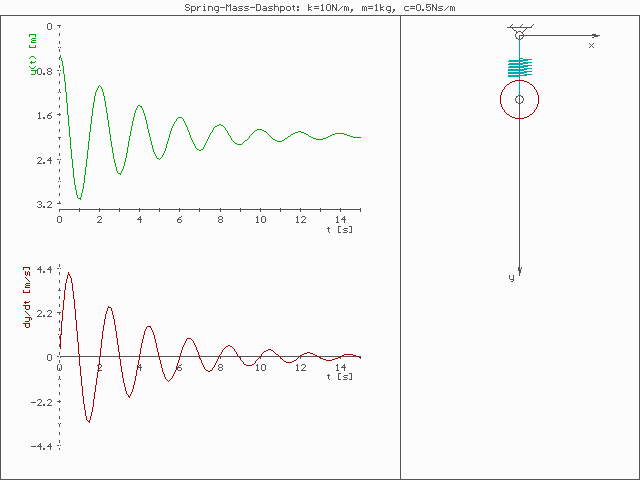

In [28]:
from IPython.display import Image

Image('https://upload.wikimedia.org/wikipedia/commons/f/fa/Spring-mass_under-damped.gif')

In [29]:
# Let's mix wet friction with dry friction, this makes the behavior
# of the system dependent on the initial condition, something
# may be interesting to study by running an exhaustive simluation

def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

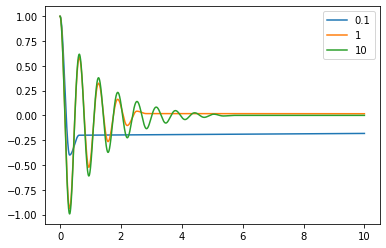

In [31]:
plot(*simulate_spring_mass_funky_damper(0.1))
plot(*simulate_spring_mass_funky_damper(1))
plot(*simulate_spring_mass_funky_damper(10))
legend(['0.1', '1', '10'])

In [32]:
%time _ = simulate_spring_mass_funky_damper(0.1)

CPU times: user 280 ms, sys: 3.37 ms, total: 284 ms
Wall time: 283 ms


Alright, so if I run this for initial conditions between 0 and 10000 on 0.1 increments the total time taken will be 25000 seconds, which is about 7 hours...

Let's `@njit` this sucker!

In [36]:
@njit
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

_ = simulate_spring_mass_funky_damper(0.1)

In [37]:
%time _ = simulate_spring_mass_funky_damper(0.1)

CPU times: user 1.68 ms, sys: 305 Âµs, total: 1.98 ms
Wall time: 1.99 ms


Hoooo boy ... that's like 200x faster, decreasing the total time for the proposed simulation to only 200 seconds from 7 hours! It's important to note that your code will start to look more and more like "What if C were Python", which I feel is an OK compromise for the performance gains.

Let's make sure the data looks correct (spoiler alert: it does)

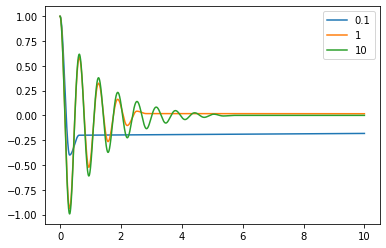

In [39]:
plot(*simulate_spring_mass_funky_damper(0.1))
plot(*simulate_spring_mass_funky_damper(1))
plot(*simulate_spring_mass_funky_damper(10))
legend(['0.1', '1', '10'])

Now let's say for the sake of argument that 200 seconds is too slow (maybe I need to run the whole simulation multiple times).

We can obviously turn to threading. Let's use ThreadPoolExecutor. I have 8 cores available, so let's try to use them (I'm going to run uptill 1000 because of ram considerations instead of 10000).

In [40]:
%%time
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(8) as ex:
    ex.map(simulate_spring_mass_funky_damper, np.arange(0, 1000, 0.1))

CPU times: user 19.2 s, sys: 469 ms, total: 19.6 s
Wall time: 19.3 s


Hmm, that doesn't actually seem faster, and looking at htop it didn't look like all the cores were being used. This is because by default Numba functions do not release the **global interpreter lock**. Let's do that explicitly.

In [41]:
@njit(nogil=True)
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit(nogil=True)
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

# compile
_ = simulate_spring_mass_funky_damper(0.1)

In [50]:
%%time
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(8) as ex:
    ex.map(simulate_spring_mass_funky_damper, np.arange(0, 1000, 0.1))

CPU times: user 13 s, sys: 53.4 ms, total: 13 s
Wall time: 1.83 s


Thaaaat's more like it! It's useful to note that Numba can actually natively multiprocess your code, though you'll need to define a wrapper function in this case.

In [58]:
from numba import prange
@njit(nogil=True, parallel=True)
def run_sims(end=1000):
    for x0 in prange(int(end/0.1)):
        if x0 == 0:
            continue
        simulate_spring_mass_funky_damper(x0*0.1)
        
run_sims()

In [60]:
%time run_sims()

CPU times: user 12.1 s, sys: 23.4 ms, total: 12.1 s
Wall time: 1.62 s


By avoiding some of the overhead of python threading we may gain a little bit of performance, though controlling the behavior of threads here becomes a bit more difficult (more information here https://numba.pydata.org/numba-doc/dev/reference/envvars.html#threading-control)

Deeper topics to discover here 
https://numba.pydata.org/numba-doc/dev/user/5minguide.html#other-things-of-interest

Supported python and numpy features 
https://numba.pydata.org/numba-doc/dev/reference/pysupported.html
https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

Important differences from python https://numba.pydata.org/numba-doc/dev/reference/pysemantics.html

Defining types to compile at definition time: http://numba.pydata.org/numba-doc/latest/user/jit.html#eager-compilation

Function factories https://numba.pydata.org/numba-doc/dev/user/generated-jit.html

Experimental version of jitted classes https://numba.pydata.org/numba-doc/dev/user/jitclass.html

Debugging https://numba.pydata.org/numba-doc/dev/user/troubleshoot.html

Dealing with types https://numba.pydata.org/numba-doc/dev/reference/types.html

Ahead of time compilation for deployment https://numba.pydata.org/numba-doc/dev/user/pycc.html

Using approximate fastmath https://numba.pydata.org/numba-doc/dev/user/performance-tips.html#fastmath

Deeper control of threading via tbb and/or omp https://numba.pydata.org/numba-doc/dev/user/threading-layer.html

Easily put your computation on a GPU!
https://numba.pydata.org/numba-doc/dev/cuda/index.html
https://numba.pydata.org/numba-doc/dev/roc/index.html

F.A.Qs https://numba.pydata.org/numba-doc/dev/user/faq.html